In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using ControlNet to control image generation

This tutorial illustrates how to use MONAI Generative Models to train a ControlNet [1]. ControlNets are hypernetworks that allow for supplying extra conditioning to ready-trained diffusion models. In this example, we will walk through training a ControlNet that allows us to specify a whole-brain mask that the sampled image must respect.



In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Freeze the diffusion model and train a ControlNet
3. Conditional sampling with the ControlNet

[1] - Zhang et al. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup environment

In [ ]:
import os
import tempfile
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


from generative.inferers import ControlNetDiffusionInferer
from generative.networks.nets import DiffusionModelUNet, ControlNet
from generative.networks.schedulers import DDPMScheduler

print_config()

### Setup data directory

In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/tmp/tmpb89d70u5/" #tempfile.mkdtemp() if directory is None else directory

### Set deterministic training for reproducibility

In [8]:
set_determinism(42)

## Setup BRATS dataset

We now download the BraTS dataset and extract the 2D slices from the 3D volumes.


### Specify transforms
We create a rough brain mask by thresholding the image.

In [9]:
channel = 0
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image"], pixdim=(3.0, 3.0, 2.0), mode="bilinear"),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["image"], times=1, names=["mask"]),
        transforms.Lambdad(keys=["mask"], func=lambda x: torch.where(x > 0.1, 1, 0)),
        transforms.FillHolesd(keys=["mask"]),
        transforms.CastToTyped(keys=["mask"], dtype=np.float32),
    ]
)

### Load training and validation datasets

In [10]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(train_ds)}")
print(f'Train image shape {train_ds[0]["image"].shape}')

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,
    seed=0,
    transform=train_transforms,
)
print(f"Length of val data: {len(val_ds)}")
print(f'Validation image shape {val_ds[0]["image"].shape}')

2023-12-13 16:10:42,349 - ERROR - check_hash failed 7b218bce011d7f4c971c0c147f86cf2d.


RuntimeError: md5 check of existing file failed: filepath=/tmp/tmpb89d70u5/Task01_BrainTumour.tar, expected md5=240a19d752f0d9e9101544901065d872.

In [ ]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True)

### Visualise the images and masks

In [ ]:
check_data = first(train_loader)
print(f"Batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    (
        torch.cat(
            [
                check_data["image"][0, 0],
                check_data["image"][1, 0],
                check_data["image"][2, 0],
                check_data["image"][3, 0],
            ],
            dim=1,
        ),
        torch.cat(
            [check_data["mask"][0, 0], check_data["mask"][1, 0], check_data["mask"][2, 0], check_data["mask"][3, 0]],
            dim=1,
        ),
    ),
    dim=0,
)
plt.figure(figsize=(6, 3))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Train the Diffusion model
In general, a ControlNet can be trained in combination with a pre-trained, frozen diffusion model. In this case we will quickly train the diffusion model first.

### Define network, scheduler, optimizer, and inferer

In [ ]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)


### Run training


In [ ]:
n_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Train the ControlNet

### Set up models

In [ ]:
# Create control net
controlnet = ControlNet(
    spatial_dims=2,
    in_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
    conditioning_embedding_num_channels=(16,),
)
# Copy weights from the DM to the controlnet
controlnet.load_state_dict(model.state_dict(), strict=False)
controlnet = controlnet.to(device)
# Now, we freeze the parameters of the diffusion model.
for p in model.parameters():
    p.requires_grad = False
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)
controlnet_inferer = ControlNetDiffusionInferer(scheduler)

### Run ControlNet training

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.75it/s]


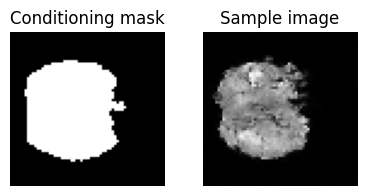

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.98it/s]


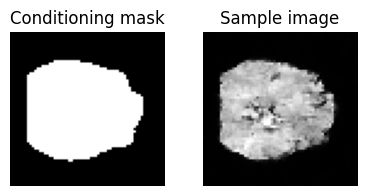

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.69it/s]


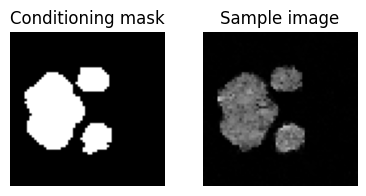

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.08it/s]


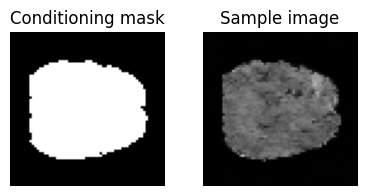

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.41it/s]


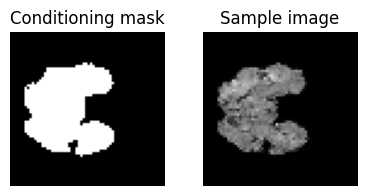

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.67it/s]


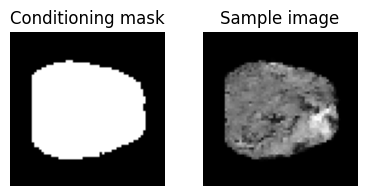

train completed, total time: 599.0462603569031.


In [13]:
n_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    controlnet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = controlnet_inferer(model, controlnet, noise, timesteps,
                                           cn_cond = masks, )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        controlnet.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, controlnet_inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    
                    noise_pred = controlnet_inferer(model, controlnet, noise, timesteps,
                                           cn_cond = masks, )
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            
            val_epoch_loss += val_loss.item()
            
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            break
        
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training with controlnet conditioning
        
        with torch.no_grad():
            with autocast(enabled=True):
                noise = torch.randn((1, 1, 64, 64)).to(device)
                sample = controlnet_inferer.sample(
                    input_noise = noise,
                    diffusion_model = model,
                    controlnet = controlnet,
                    cn_cond = masks[0, None, ...],
                    scheduler = scheduler,  
                )
        
        # Without using an inferer:
#         progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110)
#         progress_bar_sampling.set_description("sampling...")
#         sample = torch.randn((1, 1, 64, 64)).to(device)
#         for t in progress_bar_sampling:
#             with torch.no_grad():
#                 with autocast(enabled=True):
#                     down_block_res_samples, mid_block_res_sample = controlnet(
#                         x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=masks[0, None, ...]
#                     )
#                     noise_pred = model(
#                         sample,
#                         timesteps=torch.Tensor((t,)).to(device),
#                         down_block_additional_residuals=down_block_res_samples,
#                         mid_block_additional_residual=mid_block_res_sample,
#                     )
#                     sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(masks[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Sample with ControlNet conditioning
First we'll provide a few different masks from the validation data as conditioning. The samples should respect the shape of the conditioning mask, but don't need to have the same content as the corresponding validation image.

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 27.00it/s]


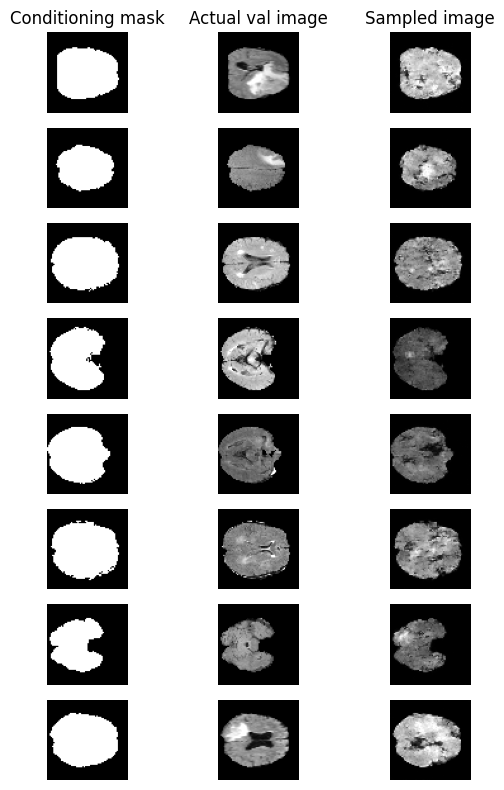

In [14]:
progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 8
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

val_batch = first(val_loader)
val_images = val_batch["image"].to(device)
val_masks = val_batch["mask"].to(device)
for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast(enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=val_masks[:num_samples, ...]
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 3, figsize=(6, 8))
for k in range(num_samples):
    plt.subplot(num_samples, 3, k * 3 + 1)
    plt.imshow(val_masks[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 3, k * 3 + 2)
    plt.imshow(val_images[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Actual val image")
    plt.subplot(num_samples, 3, k * 3 + 3)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()

What happens if we invent some masks? Let's try a circle, and a square

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.51it/s]


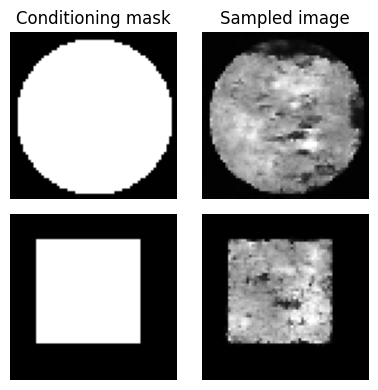

In [15]:
xx, yy = np.mgrid[:64, :64]
circle = ((xx - 32) ** 2 + (yy - 32) ** 2) < 30**2

square = np.zeros((64, 64))
square[10:50, 10:50] = 1

mask = np.concatenate((circle[None, None, ...], square[None, None, ...]), axis=0)
mask = torch.from_numpy(mask.astype(np.float32)).to(device)


progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 2
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast(enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=mask
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 2, figsize=(4, 4))
for k in range(num_samples):
    plt.subplot(num_samples, 2, k * 2 + 1)
    plt.imshow(mask[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 2, k * 2 + 2)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()